In [954]:
%reset #clear the ipython workspace variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #clear, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  ipython, please run `%reset?` for details
Don't know how to reset  workspace, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [955]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from numpy import array
from scipy.optimize import curve_fit

# Change Data Access Location For Google Drive



In [956]:
#data is on google drive so need to load
from google.colab import drive
drive.mount('/content/drive')
#this line needs to be changed depending on file structure of google drive
os.chdir('/content/drive/MyDrive/WVU_GradStudents_ShareFolder/Jacob_Research/New LSTM Crack')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Inputs

In [957]:
# Use the datapoint every (interval) point
interval = 1000
# How Many datapoints around the selected to use
# For 0, Just uses the data in front
# For others, Uses (avg) in front and behind
avg = 50
# Desired Temperature to generate data for
desired_temp = 348
# Desired Force to generate data for
force = 1600
# Add Noise? 0=no 1=yes
add_noise = 1

In [958]:
#this function computes how to offset the initial crackheight. should be set to zero.
def auto_crackoffset(crack_series):
  crack_avg = 0
  crack_offset = 0
  num_avg = 100
  #for i in range(0,num_avg):
  #  crack_avg += crack_series[i]
  crack_offset = np.max(crack_series[0:100]) #ended up offsetting my maximum value in the first 100 entries.
  return -crack_offset

               Time  Crack Length  Force    Temp
0         175.97656      0.100161   1600  308.15
1         176.17188      0.112326   1600  308.15
2         176.36719      0.069662   1600  308.15
3         176.56250      0.079680   1600  308.15
4         176.75781      0.032376   1600  308.15
...             ...           ...    ...     ...
306529  83604.88543      0.372103   1600  308.15
306530  83605.08143      0.366241   1600  308.15
306531  83605.27643      0.361021   1600  308.15
306532  83605.47143      0.348622   1600  308.15
306533  83605.66743      0.372559   1600  308.15

[306534 rows x 4 columns]


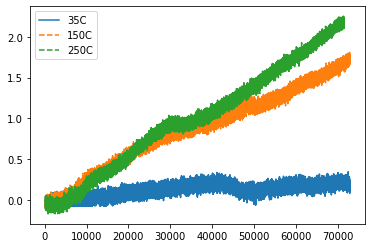

In [959]:
if force==1600:
  T1 = './Test/HeatTreated/t35_4-3-21_R05_1600N_testing.csv'
  T2 = './Test/HeatTreated/t150_4-15-21_R05_1600N_testing.csv'
  T3 = './Test/HeatTreated/t250_4-8-21_R05_1600N_testing.csv'
elif force == 1700:
  T1 = './Test/HeatTreated/t35_4-2-21_R05_1700N_testing.csv'
  T2 = './Test/HeatTreated/t150_4-13-21_R05_1700N_testing.csv'
  T3 = './Test/HeatTreated/t250_4-7-21_R05_1700N_testing.csv'
else:
  T1 = './Test/HeatTreated/t35_4-19-21_R05_1800N_testing.csv'
  T2 = './Test/HeatTreated/t150_4-12-21_R05_1800N_testing.csv'
  T3 = './Test/HeatTreated/t250_4-21-21_R05_1800N_testing.csv'
#
#
T1_df = pd.read_csv(T1)
T1_arr = np.array(T1_df)
T2_df = pd.read_csv(T2)
T2_arr = np.array(T2_df)
T3_df = pd.read_csv(T3)
T3_arr = np.array(T3_df)

print(T1_df)

#Adjust the Size of the arrays to take into consideration the need for same
#length vector operations. Set to min length
#
# column1 = time, column2 = crack length, column3 = force, column4 = temperature
min_size = min(len(T1_arr),len(T2_arr),len(T3_arr))


#Offset Crack to Zero by reading first 100 crack entries and offsetting to zero
offset_crack = 1 # 0=no 1=yes,auto 2=yes,manual

if offset_crack == 1:
  T1_x = T1_arr[:min_size,0] #time
  T1_y = T1_arr[:min_size,1]+auto_crackoffset(T1_arr[:min_size,1]) #crack length
  T2_x = T2_arr[:min_size,0] #we need to check initial crack lengths
  T2_y = T2_arr[:min_size,1]+auto_crackoffset(T2_arr[:min_size,1]) #we need to check initial crack lengths
  T3_x = T3_arr[:min_size,0]
  T3_y = T3_arr[:min_size,1]+auto_crackoffset(T3_arr[:min_size,1])
elif offset_crack == 2:
  if force == 1600:
    T1_x = T1_arr[:min_size,0] #t35_4-3-21_R05_1600N_testing.csv
    T1_y = T1_arr[:min_size,1] #crack length
    T2_x = T2_arr[:min_size,0]+1.7e4 #t150_4-15-21_R05_1600N_testing.csv
    T2_y = T2_arr[:min_size,1]#-0.4
    T3_x = T3_arr[:min_size,0] #t250_4-8-21_R05_1600N_testing.csv
    T3_y = T3_arr[:min_size,1]
  elif force == 1700:
      T1_x = T1_arr[:min_size,0] #t35_4-2-21_R05_1700N_testing.csv
      T1_y = T1_arr[:min_size,1] #crack length
      T2_x = T2_arr[:min_size,0]+2000 #t150_4-13-21_R05_1700N_testing.csv
      T2_y = T2_arr[:min_size,1] 
      T3_x = T3_arr[:min_size,0] #t250_4-7-21_R05_1700N_testing.csv
      T3_y = T3_arr[:min_size,1]
  else:
      T1_x = T1_arr[:min_size,0]+1.0e4 #t35_4-19-21_R05_1800N_testing.csv
      T1_y = T1_arr[:min_size,1]#-0.4 #crack length
      T2_x = T2_arr[:min_size,0] #t150_4-12-21_R05_1800N_testing.csv
      T2_y = T2_arr[:min_size,1] 
      T3_x = T3_arr[:min_size,0]+1.0e4 #t250_4-21-21_R05_1800N_testing.csv
      T3_y = T3_arr[:min_size,1]#-0.4
else:
  T1_x = T1_arr[:min_size,0] #time
  T1_y = T1_arr[:min_size,1] #crack length
  T2_x = T2_arr[:min_size,0] #we need to check initial crack lengths
  T2_y = T2_arr[:min_size,1] #we need to check initial crack lengths
  T3_x = T3_arr[:min_size,0]
  T3_y = T3_arr[:min_size,1]

#plot data to compare reshape
fig, (ax) = plt.subplots(1,1)
ax.plot(T1_x,T1_y, '-', label='35C') # 
ax.plot(T2_x,T2_y, '--', label='150C')
ax.plot(T3_x,T3_y, '--', label='250C')
ax.legend()
plt.show()

# Fit Data to 2-D polynomial

Create Temperature inputs for given number of points

In [960]:
i = 0
X = []
while i < len(T1_x):
  # Temperatures to use are defined below, Should Correspond to
  # Data in use
  X_timestep = [[308.15/700],[433.15/700],[523.15/700]] #normalize the temperature
  X.append(X_timestep)
  i += 1

# Array of temperatures
# Takes form
# [[T1]
#  [T2]
#  [T3]]
x = np.asarray(X)

Create's Time inputs for given number of points

In [961]:
max_time = np.amax([T1_x,T2_x,T3_x]) #time
y = np.column_stack((T1_x,T2_x,T3_x)) #horizontal stack data
print(y)

[[  175.9765597   175.9765591   175.9765631]
 [  176.1718797   176.1718791   176.1718731]
 [  176.3671897   176.3671891   176.3671831]
 ...
 [72875.5884297 72875.5872891 71482.0334531]
 [72875.7844297 72875.7822891 71482.2284531]
 [72875.9794297 72875.9772891 71482.4234531]]


Create the Vector of Crack Lengths to fit the curve to

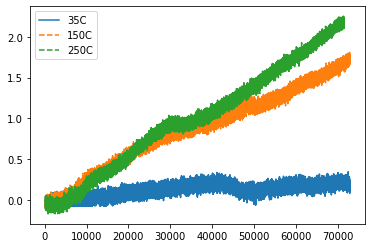

In [962]:
#max_crack = np.amax([T1_y,T2_y,T3_y])
Z = np.column_stack((T1_y,T2_y,T3_y)) #horizontal stack data

#plot data to compare reshape
fig, (ax) = plt.subplots(1,1)
ax.plot(y[:,0],Z[:,0], '-', label='35C') # 
ax.plot(y[:,1],Z[:,1], '--', label='150C')
ax.plot(y[:,2],Z[:,2], '--', label='250C')
ax.legend()
plt.show()

Generate coefficients for the polynomials

In [963]:
coeff_mtx = []
X = x.flatten() #temperature
Y = y.flatten() #time

# 2D polynomial X,Y values for previous Timesteps and Temperatures
# we want to force the z-intercept to be zero at Y=0
#A = np.array([X*Y*0, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
A = np.array([X*Y*0, X, Y, X**2, X**2*Y, X**2*Y**2, (Y**2)*0, (X*Y**2)*0, X*Y*0]).T #the polynomial has been modified based on physics and relationship of time and temp
# Target Values
B = Z.flatten()

# Z=A*B
# Fit Curve
coeff, r, rank, s = np.linalg.lstsq(A, B)
# Generate Coeff matrix and save for later
coeff_mtx.append(coeff)
coeff_mtx = np.asarray(coeff_mtx)
print(coeff_mtx)

[[ 0.00000000e+00  8.42014327e-01 -1.32715846e-05 -1.42723228e+00
   8.88532908e-05 -5.51441413e-11  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


# Generate New Data

Generate time and temperature Vectors

In [964]:
def create_times(tlen):
  times = []
  t=0
  times.append(t)
  for i in range(1,max_len):
    if (i%512==0):
      t=t+39.45312999999999
      times.append(t)
    else:
      t=t+0.19531
      times.append(t)
  return np.array(times)

In [965]:
# Generate data for number of points equal to the smallest amount of data read in
# we need to do some complicated shit here because there is a change in timestep every 512 steps.
# don't have time to fix this but we should resamples data. 
max_len = np.amax([len(T1_x),len(T2_x),len(T3_x)]) #time
times = create_times(max_len)
print(times)

# Temperature is (desired_temp)
temp = np.asarray([desired_temp/700])

[0.00000000e+00 1.95310000e-01 3.90620000e-01 ... 7.26260939e+04
 7.26262892e+04 7.26264845e+04]


Generate the New Data using 2-D polynomial and coefficients

In [966]:
vals = []

# Access Coefficient Matrix
for i in coeff_mtx:
  # Access desired Temperature
  for j in temp:
    # Access number of datapoints to create
    for k in times:
      # From before the X value is Temperature
      coeff_x = j
      # From before the Y value is time
      coeff_y = k
      # Use Coefficients and X and Y values to calculate the Crack Length at a time and temperature
      val = i[0] + coeff_x*i[1] + coeff_y*i[2] + coeff_x**2*i[3] + coeff_x**2*coeff_y*i[4] + coeff_x**2*coeff_y**2*i[5] + coeff_y**2*i[6] + coeff_x*coeff_y**2*i[7] + coeff_x*coeff_y*i[8]
      vals.append([coeff_x, coeff_y, val])

vals = np.asarray(vals).reshape(len(temp), len(times),3)

Generate Noise to Imitate Real Noise In Dataset

In [967]:
#this function sets any cracklength that is negative to zero. should be necessary if autocrack length function is enabled above.
def check_ncrack(crack_series):
  crack_new = []
  for i in range(0,len(crack_series)):
    if crack_series[i]<0:
      crack=0.E-12
    else:
      crack=crack_series[i]
    crack_new.append(crack)
  return np.asarray(crack_new)

In [968]:
#check for negative values and set to zero.
vals[0,:,2] = check_ncrack(vals[0,:,2])

# Generate Noise based around 0 with deviation of .010 in shape of Crack Length Information
noise = np.random.normal(0,.025, vals[0,:,2].shape)
# Add in Noise
if add_noise > 0:
  vals[0,:,2] = vals[0,:,2] + noise

Plot Crack Length Data For Preview

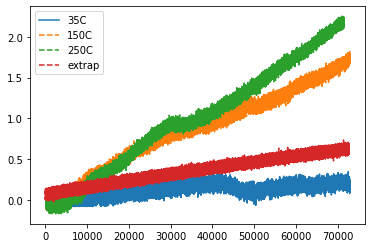

In [969]:
fig, (ax) = plt.subplots(1,1)
ax.plot(y[:,0],Z[:,0], '-', label='35C') # 
ax.plot(y[:,1],Z[:,1], '--', label='150C')
ax.plot(y[:,2],Z[:,2], '--', label='250C')
ax.plot(vals[0,:,1],vals[0,:,2], '--', label='extrap')
ax.legend()
plt.show()

Create Force Vector for Desired Force

In [970]:
len_p = len(vals[0,:,1])
vals_force = force*np.ones(len_p,)
vals_temp = desired_temp*np.ones(len_p,)
out_val = np.vstack([vals[0,:,1],vals[0,:,2],vals_force,vals_temp])
print(out_val)

[[0.00000000e+00 1.95310000e-01 3.90620000e-01 ... 7.26260939e+04
  7.26262892e+04 7.26264845e+04]
 [3.89244468e-02 2.74860100e-02 4.97401861e-02 ... 5.88032222e-01
  5.83945558e-01 6.22367665e-01]
 [1.60000000e+03 1.60000000e+03 1.60000000e+03 ... 1.60000000e+03
  1.60000000e+03 1.60000000e+03]
 [3.48000000e+02 3.48000000e+02 3.48000000e+02 ... 3.48000000e+02
  3.48000000e+02 3.48000000e+02]]


Properly Format DataFrame and Save

In [971]:
# This is all just formatting to get everything in the form I use
dataframe = pd.DataFrame(out_val[:,:].swapaxes(0,1),columns=['Time', 'Crack Length', 'Force', 'Temperature'])
print(dataframe)

#dataframe.insert(3,'Force',force_arr)
#dataframe.rename(columns={0:'Temp'}, inplace=True)
#dataframe.rename(columns={1:'Timestep'}, inplace=True)
#dataframe.rename(columns={2:'Crack Length'}, inplace=True)
#dataframe = dataframe[['Timestep', 'Crack Length', 'Force','Temp']]
#save
if add_noise>0:
  dataframe.to_csv('./Predict/HeatTreated/{}N_HT_{}K_noise.csv'.format(force,desired_temp), index=False)
else:
  dataframe.to_csv('./Predict/HeatTreated/{}N_HT_{}K.csv'.format(force,desired_temp), index=False)

               Time  Crack Length   Force  Temperature
0           0.00000      0.038924  1600.0        348.0
1           0.19531      0.027486  1600.0        348.0
2           0.39062      0.049740  1600.0        348.0
3           0.58593      0.074236  1600.0        348.0
4           0.78124      0.067263  1600.0        348.0
...             ...           ...     ...          ...
267126  72625.70328      0.610472  1600.0        348.0
267127  72625.89859      0.610511  1600.0        348.0
267128  72626.09390      0.588032  1600.0        348.0
267129  72626.28921      0.583946  1600.0        348.0
267130  72626.48452      0.622368  1600.0        348.0

[267131 rows x 4 columns]
